In [ ]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
#import torch
#from torch.utils.data import DataLoader, TensorDataset
#from transformers import DistilBertTokenizer, DistilBertModel
#from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [ ]:
# Reading the file and showing the examplatory output
final_df = pd.read_csv("Final_dataset_balanced.csv")
#Show all columns
pd.set_option('display.max_columns', None)
final_df.tail(5)

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,LineOfCode,LargestLineLength,HasTitle,Title,DomainTitleMatchScore,URLTitleMatchScore,HasFavicon,Robots,IsResponsive,NoOfURLRedirect,NoOfSelfRedirect,HasDescription,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasSocialNet,HasSubmitButton,HasHiddenFields,HasPasswordField,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label,status_code,Meta_Description,Headings,Page_Content,Word_Count
2680,mw180812.html,http://www.sam-sdelai.blogspot.com,33,www.sam-sdelai.blogspot.com,27,0,com,61.430556,0.473684,0.522907,0.061651,3,2,0,0,0.0,19,0.576,0,0.0,0,0,0,3,0.091,0,11,74,1,sam-sdelaiblogspot,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,200.0,На сайте Делай Сам Своими Руками вы найдете по...,Делай Сам Своими Руками! Pages LED пасхальные ...,Pages Posts by Admin LED ...,128.0
2681,mw51570.html,http://www.is-a-hunter.com,25,www.is-a-hunter.com,19,0,com,70.476190,0.636364,0.522907,0.063236,3,1,0,0,0.0,11,0.440,0,0.0,0,0,0,3,0.120,0,2,34,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,200.0,"As a leading dynamic DNS provider, Dyn elimina...",Dynamic DNS Create an easy to remember hostnam...,Dynamic DNS Home Users Whats the solution for ...,344.0
2682,mw51096.html,http://www.quicksytes.com,24,www.quicksytes.com,18,0,com,84.446323,1.000000,0.522907,0.052505,3,1,0,0,0.0,12,0.500,0,0.0,0,0,0,1,0.042,0,2,33,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,200.0,NaN,Your browser is out of date! Free Dynamic DNS ...,Remote Access Dynamic DNS Create a Free DDNS...,678.0
2683,mw134262.html,http://www.pasarwood.com,23,www.pasarwood.com,17,0,com,72.244898,1.000000,0.522907,0.066066,3,1,0,0,0.0,11,0.478,0,0.0,0,0,0,1,0.043,0,2,33,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,200.0,شرکت صنایع چوبی پاسار یک شرکت فعال در زمینه طر...,تحقق رویاهای شما نصب و اجرای پروژه طراحی منحصر...,Menu ...,37.0
2684,mw143141.html,http://www.ppinds.in,19,www.ppinds.in,13,0,in,67.160494,1.000000,0.005084,0.045687,2,1,0,0,0.0,7,0.368,0,0.0,0,0,0,1,0.053,0,9,72,1,ppnds,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,200.0,Parshwa Padmavati Industries is a leading manu...,PARSHWA PADMAVATI INDUSTRIES Quick Links Conta...,Printing Packaging Gifting Company in Mumbai ...,543.0


In [5]:
#checking the data types of the columns
#final_df.info()

Bert model


In [87]:
text_df = final_df[["Title", "Meta_Description", "Headings", "Page_Content"]]
text_df.head(5)

,Title,Meta_Description,Headings,Page_Content
0,latinbasket,NaN,NaN,Latin American basketball News Scores Stats An...
1,dwu,NaN,WELCOME TO DAKOTA WESLEYAN UNIVERSITY INNOVATI...,Dakota Wesleyan University Learn Live and Pla...
2,bloodyelbow,Bloody Elbow has been a leading voice in comba...,Follow us on PFL champion Impa Kasanganay was ...,Bloody Elbow UFC MMA and Boxing News UFC News...
3,masoodg,NaN,NaN,NaN
4,mantoemarati,مجموعه مزون فاریون عبایا شامل طیف گسترده ای از...,مزون فاریون عبایا مدل مانتوهای مجلسی و عربی با...,Type a keyword 09023250305 ...


In [78]:
text_df.fillna("", inplace=True)
text_df["text"] = text_df["Title"] + " " + text_df["Meta_Description"] + " " + text_df["Headings"] + " " + text_df["Page_Content"]

C:\Users\Ssawka\AppData\Local\Temp\ipykernel_14292\1395457866.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df.fillna("", inplace=True)
C:\Users\Ssawka\AppData\Local\Temp\ipykernel_14292\1395457866.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df["text"] = text_df["Title"] + " " + text_df["Meta_Description"] + " " + text_df["Headings"] + " " + text_df["Page_Content"]


In [79]:
texts = text_df["text"].tolist()

In [10]:
# Load DistilBERT model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")
model.eval()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:  48%|####8     | 252M/520M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [107]:
model.config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.52.3",
  "vocab_size": 30522
}

In [11]:
# Use CPU (or "cuda" if available and desired)
device = torch.device("cpu")
model.to(device)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [12]:
inputs = tokenizer(
    texts,
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512
)

In [13]:
# Create DataLoader
batch_size = 32
dataset = TensorDataset(inputs["input_ids"], inputs["attention_mask"])
dataloader = DataLoader(dataset, batch_size=batch_size)


In [14]:
# Inference
features = []
with torch.no_grad():
    for input_ids_batch, attention_mask_batch in tqdm(dataloader, desc="Extracting embeddings"):
        input_ids_batch = input_ids_batch.to(device)
        attention_mask_batch = attention_mask_batch.to(device)

        outputs = model(input_ids=input_ids_batch, attention_mask=attention_mask_batch)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        features.append(cls_embeddings.cpu())

Extracting embeddings: 100%|██████████| 84/84 [24:15<00:00, 17.32s/it]


In [108]:
# Stack all embeddings into a single NumPy array
X_bert = torch.cat(features).numpy()

In [ ]:
np.save("bert_embeddings_duplicates_drop.npy", X_bert) 

Random Forest and XGBoost models


In [ ]:
# Loading the saved embeddings
X_bert = np.load("bert_embeddings.npy")

In [4]:
y = final_df["label"].values
#np.save("labels.npy", y)

In [5]:
#NoOfObfuscatedChar, CharContinuationRate - 0 everywhere
#NoOfCSS -addded

test_df = final_df[["LineOfCode", "LetterRatioInURL", "NoOfCSS", "DegitRatioInURL", "NoOfPopup", "HasExternalFormSubmit", "NoOfImage","HasSubmitButton", "HasHiddenFields", "HasPasswordField", "SpacialCharRatioInURL", "URLLength", "DomainLength", "TLDLength", "IsDomainIP", "NoOfSubDomain", "label", "IsHTTPS", "HasTitle", "LargestLineLength","HasFavicon","NoOfURLRedirect", "HasDescription","HasCopyrightInfo","NoOfJS", "Word_Count"]]
pd.set_option('display.max_columns', None)
test_df.head(5)

,LineOfCode,LetterRatioInURL,NoOfCSS,DegitRatioInURL,NoOfPopup,HasExternalFormSubmit,NoOfImage,HasSubmitButton,HasHiddenFields,HasPasswordField,SpacialCharRatioInURL,URLLength,DomainLength,TLDLength,IsDomainIP,NoOfSubDomain,label,IsHTTPS,HasTitle,LargestLineLength,HasFavicon,NoOfURLRedirect,HasDescription,HasCopyrightInfo,NoOfJS,Word_Count
0,1399,0.500,6,0.0,0,0,67,0,0,0,0.038,26,19,3,0,1,1,1,1,864,1,1,1,1,16,3509.0
1,1013,0.278,6,0.0,0,1,38,0,1,0,0.056,18,11,3,0,1,1,1,1,664,0,0,0,1,9,596.0
2,5831,0.500,4,0.0,0,0,101,1,1,0,0.038,26,19,3,0,1,1,1,1,29660,1,0,1,1,17,796.0
3,4733,0.409,48,0.0,17,0,43,1,0,0,0.045,22,15,3,0,1,1,1,1,6440,0,1,0,1,19,0.0
4,1147,0.519,32,0.0,0,1,10,1,1,0,0.037,27,20,3,0,1,1,1,1,10548,1,0,1,1,40,19.0


In [ ]:
#test_df_2 = final_df[["LineOfCode", "HasCopyrightInfo", "HasTitle", "HasExternalFormSubmit", "NoOfSubDomain", "NoOfURLRedirect", "NoOfJS", "HasSubmitButton", "NoOfCSS", "label"]]

In [6]:
X_num = test_df.drop(columns=["label"], errors='ignore').values

In [7]:
X_combined = np.hstack((X_bert, X_num))

In [8]:
y = test_df["label"].values

In [ ]:
# Randomized Search for XGBoost Model
from sklearn.model_selection import RandomizedSearchCV 
import xgboost as xgb 
import numpy as np
from sklearn.preprocessing import StandardScaler 
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.15, random_state=42, shuffle = True) 

xgb_model = xgb.XGBClassifier( use_label_encoder=False, eval_metric='logloss', random_state=42 ) 
param_dist = { 'n_estimators': [50, 100, 200, 500, 1000],
              'learning_rate': [0.001, 0.01, 0.1, 0.2], 
              'max_depth': [3,4,5,8], 
              'min_child_weight': [3, 5, 7]} 

# Randomized search 
random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=10, scoring='roc_auc', cv=3, verbose=2, random_state=42, n_jobs=-1 )                                    
random_search_xgb.fit(X_train, y_train) 

print("Best parameters found:", random_search_xgb.best_params_) 
print("Best score:", random_search_xgb.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Ssawka\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:22:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters found: {'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.2}
Best score: 0.9992705950624942


In [ ]:
#XGBoost model
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.15, random_state=42, shuffle = True)


#Scaling the features
scaler = StandardScaler()
X_train[:, -X_num.shape[1]:] = scaler.fit_transform(X_train[:, -X_num.shape[1]:])
X_test[:, -X_num.shape[1]:] = scaler.transform(X_test[:, -X_num.shape[1]:])

xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    n_estimators=200,        
    learning_rate=0.05,    
    max_depth=3,             
    eval_metric='logloss',
    min_child_weight = 7
)
                              
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

c:\Users\Ssawka\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:44:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       161
           1       1.00      1.00      1.00       242

    accuracy                           1.00       403
   macro avg       1.00      1.00      1.00       403
weighted avg       1.00      1.00      1.00       403



In [ ]:
# Save model to file
joblib.dump(scaler, 'xgb_scaler.pkl')
joblib.dump(xgb_model, 'xgboost_model.pkl')

['xgboost_model_15.08_new.pkl']

In [ ]:
# RandomizedSearch for Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.15, random_state=42, shuffle = True)
rf = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [10, 25, 50],
    'max_depth': [2, 5],
    'min_samples_split': [1, 2, 5],
    'min_samples_leaf': [1, 2, 4]
}

# Randomized search
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,  
    scoring='roc_auc',  
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)


random_search_rf.fit(X_train, y_train)
print("Best parameters found:", random_search_rf.best_params_)
print("Best score:", random_search_rf.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Ssawka\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
3 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ssawka\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ssawka\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\Ssawka\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Ssawka\anaconda3\Lib\site-packag

Best parameters found: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 5}
Best score: 0.9991802165123014


In [ ]:
#Random Forest model
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.15, random_state=42, shuffle = True)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[:, -X_num.shape[1]:] = scaler.fit_transform(X_train[:, -X_num.shape[1]:])
X_test[:, -X_num.shape[1]:] = scaler.transform(X_test[:, -X_num.shape[1]:])

clf = RandomForestClassifier(n_estimators=50, max_depth = 5 , min_samples_split = 2, min_samples_leaf=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       161
           1       1.00      1.00      1.00       242

    accuracy                           1.00       403
   macro avg       1.00      1.00      1.00       403
weighted avg       1.00      1.00      1.00       403



In [ ]:
# Save model to file
joblib.dump(clf, 'random_forest.pkl')
joblib.dump(scaler, 'rf_scaler.pkl')

['rf_scaler_14.08_v1.pkl']

Model performance

In [13]:
from sklearn.metrics import accuracy_score

y_train_pred = clf.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

y_test_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")


Train accuracy: 0.9987
Test accuracy: 0.9950


Learning curve - to check whether the model is not overfitting

c:\Users\Ssawka\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:44:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ssawka\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:44:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ssawka\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:44:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Ssawka\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:44:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update

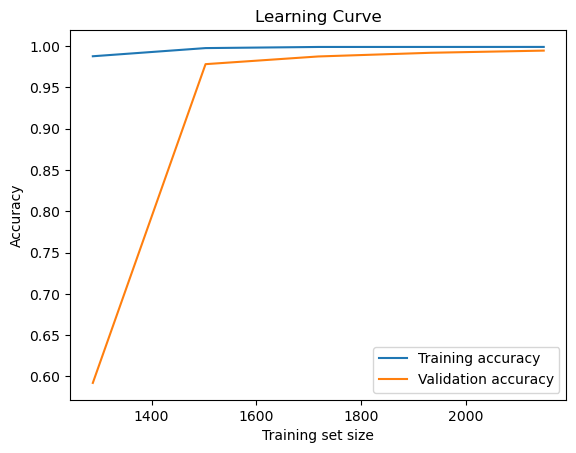

In [97]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
   xgb_model, X_combined, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label='Training accuracy')
plt.plot(train_sizes, test_mean, label='Validation accuracy')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve')
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_combined, y, cv=5)
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())


Cross-validation scores: [0.99255121 1.         0.98324022 0.98510242 0.99255121]
Mean accuracy: 0.9906890130353817


In [65]:
#For showing the feature importance
df_num_clean = test_df.drop(columns=["label"])
num_feature_names = df_num_clean.columns.tolist()
X_num = df_num_clean.values


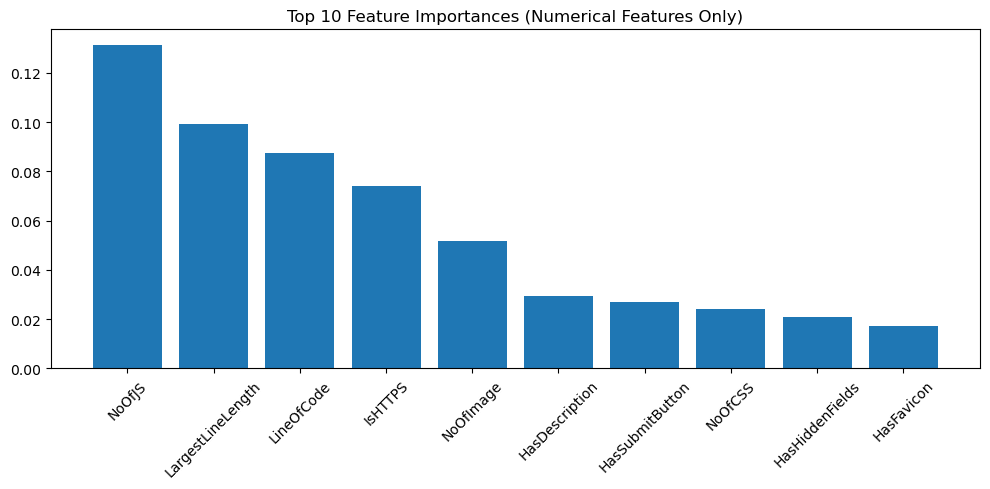

Top 10 Numerical Features by Importance:

NoOfJS: 0.1311
LargestLineLength: 0.0992
LineOfCode: 0.0876
IsHTTPS: 0.0742
NoOfImage: 0.0516
HasDescription: 0.0293
HasSubmitButton: 0.0269
NoOfCSS: 0.0241
HasHiddenFields: 0.0209
HasFavicon: 0.0173


In [52]:
#Feature importance for numerical features only - Random Forest
num_feature_importances = clf.feature_importances_[-X_num.shape[1]:]
indices = np.argsort(num_feature_importances)[::-1][:10]

plt.figure(figsize=(10, 5))
plt.title("Top 10 Feature Importances (Numerical Features Only)")
plt.bar(range(10), num_feature_importances[indices])
plt.xticks(range(10), [num_feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

print("Top 10 Numerical Features by Importance:\n")
for i in indices:
    print(f"{num_feature_names[i]}: {num_feature_importances[i]:.4f}")


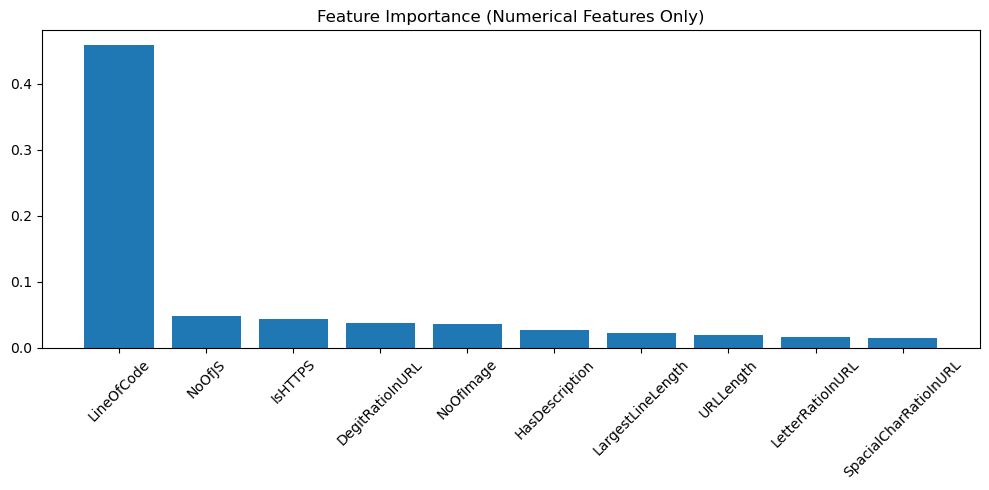

Top 10 Numerical Features by Importance:

LineOfCode: 0.4579
NoOfJS: 0.0478
IsHTTPS: 0.0428
DegitRatioInURL: 0.0366
NoOfImage: 0.0351
HasDescription: 0.0267
LargestLineLength: 0.0216
URLLength: 0.0183
LetterRatioInURL: 0.0152
SpacialCharRatioInURL: 0.0146


In [110]:
#Feature importance for numerical features only - XGBoost
num_feature_importances = xgb_model.feature_importances_[-X_num.shape[1]:]
indices = np.argsort(num_feature_importances)[::-1][:10]

plt.figure(figsize=(10, 5))
plt.title("Feature Importance (Numerical Features Only)")
plt.bar(range(10), num_feature_importances[indices])
plt.xticks(range(10), [num_feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

print("Top 10 Numerical Features by Importance:\n")
for i in indices:
    print(f"{num_feature_names[i]}: {num_feature_importances[i]:.4f}")



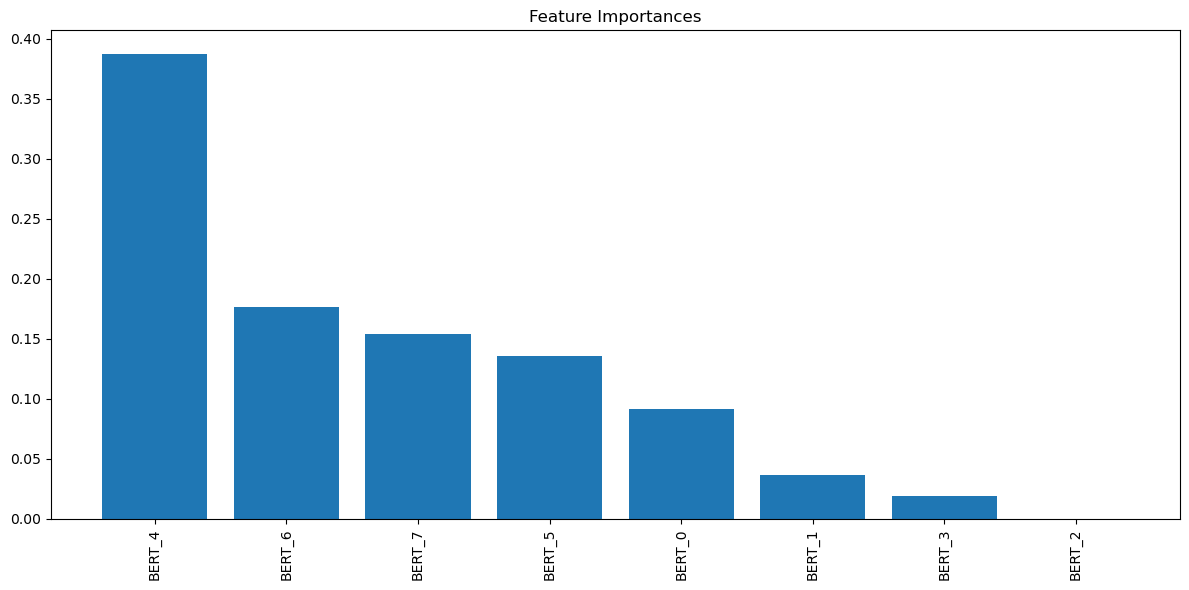

In [ ]:
#Feature importance for BERT model

#Random Forest model
importances = clf.feature_importances_

#XGBoost model
#importances = xgb_model.feature_importances_

#Bert model
feature_names = [f"BERT_{i}" for i in range(X_bert.shape[1] - X_num.shape[1])] + list(numerical_df.columns)
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


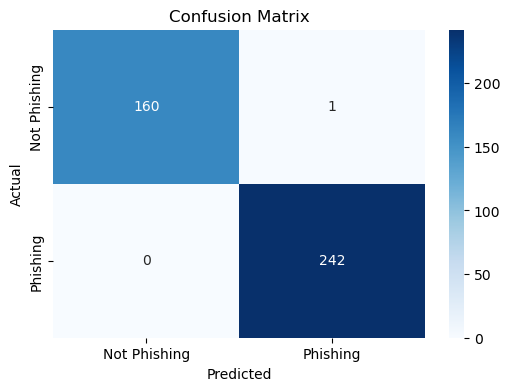

In [54]:
#Confusion matrix for random forest model
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

#Ploting heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Phishing', 'Phishing'], yticklabels=['Not Phishing', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


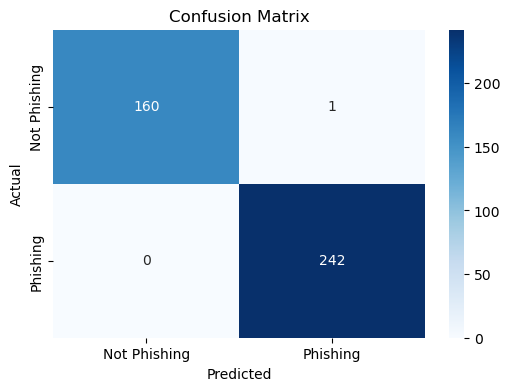

In [55]:
#Confusion matrix for xgboost model
y_pred = xgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

#Ploting the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Phishing', 'Phishing'], yticklabels=['Not Phishing', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [56]:
#Used for calculating performance metrix borh for Random Forest and XGBoost

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp / (tp + fp)
specificity = tn / (tn + fp)
accuracy = (tp +tn) / (tp + fp+tn+fn)
sensitivity = tp/ (tp + fn)

print("Precision:", precision)
print("Specificity:", specificity)

print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)

Precision: 0.9958847736625515
Specificity: 0.9937888198757764
Accuracy: 0.9975186104218362
Sensitivity: 1.0
